In [36]:
import numpy as np
import gym
import random
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Activation

env = gym.make('LunarLander-v2')

In [165]:
def Q_model(state_dim, n_action):
    model = Sequential()

    model.add(Dense(64, input_dim=state_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_action, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    return model


        
class DQL_agent():
    def __init__(self, dS, nA, max_episodes, batch_size, gamma, update_freq, epsilon, epochs=1):
        self.dS = dS
        self.nA = nA
        self.max_episodes = max_episodes
        self.batch_size = batch_size
        self.gamma = gamma
        self.update_freq = update_freq
        self.epsilon = epsilon
        self.epochs = epochs
        
        self.model = Q_model(dS, nA)
        self.target_model = Q_model(dS, nA)  
        self.memory = deque(maxlen=self.batch_size * 10)
        
        self.copy_weight()
        
    def epsilon_greedy(self, s):
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.nA)
        else:
            return np.argmax(self.model.predict(np.expand_dims(s, axis=0))[0])
        
    def update(self):
        batch = np.array(random.sample(self.memory, self.batch_size))
        s, next_s = np.vstack(batch[:,0]), np.vstack(batch[:,3])
        a, r, done = np.array(batch[:,1], dtype='int'), np.array(batch[:,2], dtype='float'), np.array(batch[:,4], dtype='bool')
        Q = self.model.predict(s) #current prediction of Q values (n_sample * n_action)
        new_Q = r #target prediction of Q values
        not_done_idx = np.where(~done)[0]
        new_Q[not_done_idx] += self.gamma * np.max(self.target_model.predict(next_s[not_done_idx, :]), axis=1)
        Q[range(Q.shape[0]), a] = new_Q #update Q of a to new_Q
        self.model.fit(x=s, y=Q, epochs=self.epoches, batch_size=self.batch_size, verbose=0)
        
    def copy_weight(self):
        self.target_model.set_weights(self.model.get_weights())
        
    def Q_learning(self, env):

        i = 0
        episode_rewards = []

        for n in tqdm(range(self.max_episodes)):
            s = env.reset()
            
            done = False
            episode_reward = 0
            while not done:
                a = self.epsilon_greedy(s)
                next_s, r, done, info = env.step(a)
                i += 1
                self.memory.append([s, int(a), r, next_s, done])
                if i % self.batch_size==0:
                    self.update()
                if i % (self.batch_size*self.update_freq) ==0 :
                    self.copy_weight()
                    
                s = next_s
                episode_reward += r
            episode_rewards.append(episode_reward)
        
        return episode_rewards

predict_sprime = self.model.predict(np.vstack(minibatch[:, 3]))
            predict_sprime_target = self.target_model.predict(np.vstack(minibatch[:, 3]))
            
            # Non-terminal update rule
            y[not_done_indices] += np.multiply(self.gamma, \
                        predict_sprime_target[not_done_indices, \
                        np.argmax(predict_sprime[not_done_indices, :][0], axis=1)][0])

In [170]:
env = gym.make('LunarLander-v2')
dS = env.observation_space.shape[0]
nA = env.action_space.n
max_episodes = 1000
batch_size = 32
gamma = 0.8
update_freq = 10
epsilon = 0.1
agent = DQL_agent(dS, nA, max_episodes, batch_size, gamma, update_freq, epsilon)

In [171]:
episode_rewards = agent.Q_learning(env)

100%|██████████| 1000/1000 [14:17<00:00,  1.17it/s]


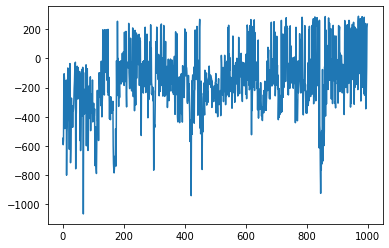

In [172]:
plt.plot(episode_rewards)